<a id="Index"></a>
<div class="alert alert-block alert-info" style="margin-top: 20px">
<font size = 3><strong>Click on the links to go to the following sections:</strong></font>
<br>
<h2>Index</h2>
<ol>
    <li><a href="#ref1">Libraries</a></li>
    <li><a href="#ref2">Load data</a></li>
    <li><a href="#ref3">Clean & Lemmatization</a></li>
    <li><a href="#ref4">Analysis</a></li>
    <li><a href="#ref5">Clusters topics</a></li>
  

</ol>    
</div>

<a id="ref1"></a>
<h2>Libraries</h2>

In [1]:
# import csv
# import os
import re
import json
import umap

import hdbscan

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from IPython.display import clear_output
from pointgrid import align_points_to_grid

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# import math
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from scipy import interpolate

#Lema
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import string

#nlp count
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation


<a href="#Index">Return to Index</a>

<a id="ref2"></a>
<h2>Load data</h2>

In [2]:
query = "Query_AI-magazines-mediacloud-2021-24"

FEATHER_FILE = query + ".feather"
df = pd.read_feather('data/' + FEATHER_FILE)

df.shape[0]

2633

In [3]:
df['media_name'].value_counts()

media_name
wired.com               929
technologyreview.com    770
theverge.com            468
theatlantic.com         339
medium.com              109
thespectrum.com          18
Name: count, dtype: int64

In [4]:
df = df[df['media_name'] == 'technologyreview.com'] # Filter by magazine
df = df.reset_index(drop=True)
df.head(1)

,id,indexed_date,language,media_name,media_url,publish_date,title,url,year,text,text_downloaded,GPE,IND,ORG
0,fa04f2a7d53cfa67cbac5db21f72131b58dc5d3ef13560...,2024-09-10 15:28:41.289382,en,technologyreview.com,technologyreview.com,2024-09-10,2024 Innovator of the Year: Shawn Shan builds ...,https://www.technologyreview.com/2024/09/10/11...,2024,2024 Innovator of the Year: Shawn Shan builds ...,True,[Midjourney],"[Shawn Shan, Shawn Shan, Shawn Shan, Shan, Sha...","[Glaze, Nightshade, MIT Technology Review, the..."


<a href="#Index">Return to Index</a>

<a id="ref3"></a>
<h2>Clean & Lemmatization</h2>

### Lematization

In [5]:
nlp = spacy.load("en_core_web_sm")
# Calculate the number of words per row
df["word_count"] = df["text"].apply(lambda x: len(x.split()))

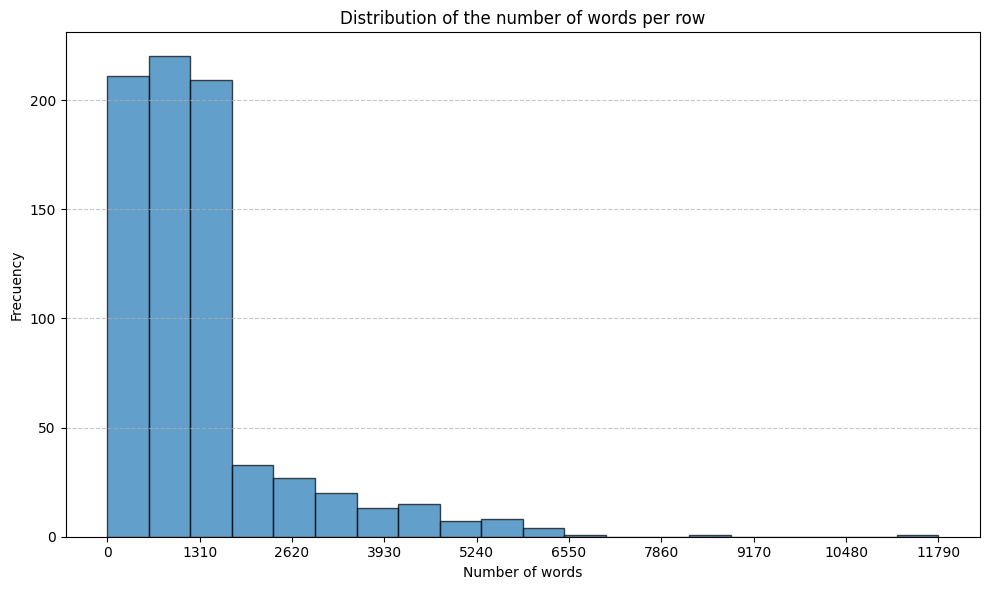

In [6]:
# Generate a histogram with adjustments
plt.figure(figsize=(10, 6))
plt.hist(df["word_count"], bins=20, edgecolor="black", alpha=0.7)  # Ajusta bins a 20 intervalos
plt.title("Distribution of the number of words per row")
plt.xlabel("Number of words")
plt.ylabel("Frecuency")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Adjusting ticks on the X-axis
plt.xticks(np.linspace(df["word_count"].min(), df["word_count"].max(), 10).astype(int))
plt.tight_layout()
plt.show()

In [7]:
df.text[1]

'What impact will AI have on video game development?\nIt could make working conditions more bearable—or it could just put people out of work.\nThis story is from The Algorithm, our weekly newsletter on AI. To get it in your inbox first, sign up here.\nVideo game development has long been plagued by fear of the “crunch”—essentially, being forced to work overtime on a game to meet a deadline. In the early days of video games, the crunch was often viewed as a rite of passage: In the last days before release, an obsessed group of scrappy developers would work late into the night to perfect their dream game.\nHowever, nowadays the crunch is less likely to be glamorized than to be seen as a form of exploitation that risks causing mental illness and burnout. Part of the issue is that crunch time used to be just before a game launched, but now whole game development periods are “crunchy.” With games getting more expensive, companies are incentivized to make even more short-term profits by sque

In [8]:
# Parsing

def parse_document(text):
    """
    Parses the text using spaCy.
    Returns a processed spaCy document.
    """
    return nlp(text)


df['parsed_doc'] = df['text'].apply(parse_document)
df['parsed_doc']



0      (2024, Innovator, of, the, Year, :, Shawn, Sha...
1      (What, impact, will, AI, have, on, video, game...
2      (To, be, more, useful, ,, robots, need, to, be...
3      (Roblox, is, launching, a, generative, AI, tha...
4      (Sponsored, \n, Integrating, security, from, c...
                             ...                        
765                                                   ()
766                                                   ()
767    (Sponsored, \n, These, five, AI, developments,...
768                                                   ()
769    (This, avocado, armchair, could, be, the, futu...
Name: parsed_doc, Length: 770, dtype: object

In [9]:
# Define custom stop words in lowercase
CUSTOM_STOP_WORDS = {'ai','say', 'year', 'way', 'use', 'need', 'technology','tech', 
                     'mit', 'review', 'datum', 'thing', 'model', 'company'}
#
# Convert custom stop words to lowercase
CUSTOM_STOP_WORDS = {word.lower() for word in CUSTOM_STOP_WORDS}

In [10]:
# Function to clean tokens
def clean_tokens(doc):
    """
    Cleans tokens from a SpaCy-parsed document:
    - Filters tokens by POS tags: PROPN, NOUN.
    - Uses lemmatized forms (lemma_) in lowercase.
    - Excludes stopwords, punctuation, and custom-defined words.
    """
    tokens = [
        token.lemma_.lower().strip() for token in doc
        if token.pos_ in {"PROPN", "NOUN"}  # Keep specific POS tags
        and token.is_alpha                  # Keep only alphabetic tokens
        and token.lemma_.lower() not in STOP_WORDS  # Exclude default SpaCy stopwords
        and token.lemma_.lower() not in CUSTOM_STOP_WORDS  # Exclude custom-defined words
    ]
    return tokens

# Procesar los textos con spaCy para convertirlos en objetos Doc
df['parsed_doc'] = df['parsed_doc'].apply(nlp)

# Aplicar la función clean_tokens
df['parsed_lemmas'] = df['parsed_doc'].apply(lambda doc: ' '.join(clean_tokens(doc)))


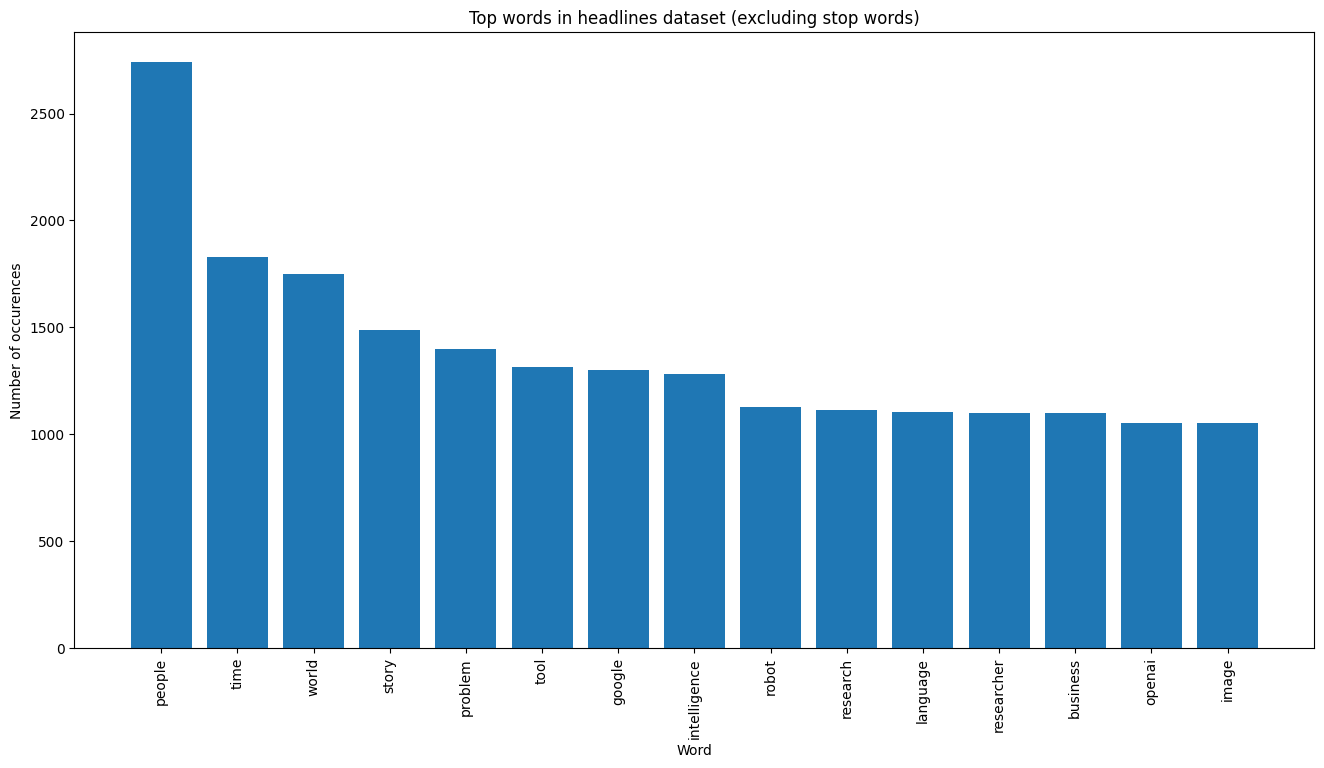

In [11]:
# Define helper functions
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])


count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=15,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=df['parsed_lemmas'])

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in headlines dataset (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

### Save clean text

In [12]:
df.to_csv('Query_AI_text_clean.csv', index=False)

<a href="#Index">Return to Index</a>

<a id="ref4"></a>
<h2>Analysis</h2>

In [13]:
df = pd.read_csv('Query_AI_text_clean.csv')
df.head(3)

,id,indexed_date,language,media_name,media_url,publish_date,title,url,year,text,text_downloaded,GPE,IND,ORG,word_count,parsed_doc,parsed_lemmas
0,fa04f2a7d53cfa67cbac5db21f72131b58dc5d3ef13560...,2024-09-10 15:28:41.289382,en,technologyreview.com,technologyreview.com,2024-09-10,2024 Innovator of the Year: Shawn Shan builds ...,https://www.technologyreview.com/2024/09/10/11...,2024,2024 Innovator of the Year: Shawn Shan builds ...,True,['Midjourney'],['Shawn Shan' 'Shawn Shan' 'Shawn Shan' 'Shan'...,['Glaze' 'Nightshade' 'MIT Technology Review' ...,941,2024 Innovator of the Year: Shawn Shan builds ...,innovator shawn shan tool artist shan glaze ni...
1,00dd081954ae78bb816f397a15f0a5f1f08cc32519c4e4...,2024-09-10 11:19:31.849908,en,technologyreview.com,technologyreview.com,2024-09-10,What impact will AI have on video game develop...,https://www.technologyreview.com/2024/09/10/11...,2024,What impact will AI have on video game develop...,True,['Midjourney' 'LA' 'Netherlands'],['Roblox' 'Roblox' 'AI' 'Niall' 'Josh Kahn'],['a16z' 'Ubisoft' 'ChatGPT' 'ChatGPT' 'AI' 'AI...,1366,What impact will AI have on video game develop...,impact video game development working conditio...
2,dd81b8f5f198bf90f181d1608d05a1955803324090ed07...,2024-09-09 23:21:56.858516,en,technologyreview.com,technologyreview.com,2024-09-09,"To be more useful, robots need to become lazier",https://www.technologyreview.com/2024/09/09/11...,2024,"To be more useful, robots need to become lazie...",True,['Netherlands' 'Tech United' 'UK'],['René van de Molengraft' 'Van de Molengraft' ...,['Eindhoven University of Technology' 'RoboCup...,1772,"To be more useful, robots need to become lazie...",robot smarter processing machine energy world ...


In [14]:
df['parsed_lemmas'].isnull().sum()

np.int64(180)

### Temperature

In [15]:
min_year = df['year'].min(); max_year = df['year'].max() # Find min and max
mid_year = (max_year + min_year) // 2 # Calculate the middle year
df['temperature'] = df['year'].apply(lambda x: x - mid_year) # Apply the transformation

# Function to interpolate between red (#FF0000) and blue (#0000FF)
def year_to_color(year, min_year, max_year):
    norm = (year - min_year) / (max_year - min_year)  # Normalize between 0 and 1
    return mcolors.to_hex((1-norm, 0, norm))  # Interpolate between red (1, 0, 0) and blue (0, 0, 1)

# Apply the color function based on the year
df['color'] = df['year'].apply(lambda x: year_to_color(x, min_year, max_year))


df.sample(3)

,id,indexed_date,language,media_name,media_url,publish_date,title,url,year,text,text_downloaded,GPE,IND,ORG,word_count,parsed_doc,parsed_lemmas,temperature,color
642,caa22bf0de94adb678a12fa892a8e59850746a7e38f378...,2024-07-03 03:39:42.460467,en,technologyreview.com,technologyreview.com,2022-03-16,What do psychedelic drugs do to our brains? AI...,https://www.technologyreview.com/2022/03/16/10...,2022,What do psychedelic drugs do to our brains? AI...,True,['Montreal' 'New York City' 'Cambridge' 'Massa...,['Danilo Bzdok' 'Frederick Barrett' 'Dillan Di...,['McGill University' 'Bzdok' 'SUNY Downstate H...,824,What do psychedelic drugs do to our brains? AI...,drug brain word people trip experience drug il...,0,#aa0055
119,6c041fad7035f50ad38da3d3f72f37a79dd92b33ad3e6c...,2024-05-13 23:25:20.756984,en,technologyreview.com,technologyreview.com,2024-05-13,OpenAI’s new GPT-4o lets people interact using...,https://www.technologyreview.com/2024/05/13/10...,2024,OpenAI’s new GPT-4o lets people interact using...,True,[],['Siri' 'Mira Murati' 'GPT-4' 'Siri' 'Barret Z...,['OpenAI' 'Alexa' 'GPT' 'OpenAI' 'Google' 'Ope...,845,OpenAI’s new GPT-4o lets people interact using...,openai people voice video flagship version ass...,2,#0000ff
723,fbbf192d521ca6c7fc22d9c91bb9ec6b8e29d52dc2fd4b...,2024-08-30 20:15:58.758410,en,technologyreview.com,technologyreview.com,2021-06-10,"Clinical trials are better, faster, cheaper wi...",https://www.technologyreview.com/2021/06/10/10...,2021,NaN,False,[],[],[],0,NaN,NaN,-1,#ff0000


In [16]:
# Filter rows where word_count <= 10
df = df[df["word_count"] >= 10]
df.shape

(590, 19)

### Term Frequency

In [17]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

vectorizer = CountVectorizer(
    lowercase=False,
    tokenizer=lambda key: key,  # Use if 'entities' is a list of lists
    token_pattern=None  # Disable token_pattern since we are using a custom tokenizer
)

# Convert 'entities' column (which is a list of lists) to a list
entities = df["parsed_lemmas"].to_list()

# Vectorize the list of entities
X = vectorizer.fit_transform(entities)

# Apply TF-IDF transformation
tfidf = TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf.fit(X)
train_data = tfidf.transform(X)

df.head(3)

,id,indexed_date,language,media_name,media_url,publish_date,title,url,year,text,text_downloaded,GPE,IND,ORG,word_count,parsed_doc,parsed_lemmas,temperature,color
0,fa04f2a7d53cfa67cbac5db21f72131b58dc5d3ef13560...,2024-09-10 15:28:41.289382,en,technologyreview.com,technologyreview.com,2024-09-10,2024 Innovator of the Year: Shawn Shan builds ...,https://www.technologyreview.com/2024/09/10/11...,2024,2024 Innovator of the Year: Shawn Shan builds ...,True,['Midjourney'],['Shawn Shan' 'Shawn Shan' 'Shawn Shan' 'Shan'...,['Glaze' 'Nightshade' 'MIT Technology Review' ...,941,2024 Innovator of the Year: Shawn Shan builds ...,innovator shawn shan tool artist shan glaze ni...,2,#0000ff
1,00dd081954ae78bb816f397a15f0a5f1f08cc32519c4e4...,2024-09-10 11:19:31.849908,en,technologyreview.com,technologyreview.com,2024-09-10,What impact will AI have on video game develop...,https://www.technologyreview.com/2024/09/10/11...,2024,What impact will AI have on video game develop...,True,['Midjourney' 'LA' 'Netherlands'],['Roblox' 'Roblox' 'AI' 'Niall' 'Josh Kahn'],['a16z' 'Ubisoft' 'ChatGPT' 'ChatGPT' 'AI' 'AI...,1366,What impact will AI have on video game develop...,impact video game development working conditio...,2,#0000ff
2,dd81b8f5f198bf90f181d1608d05a1955803324090ed07...,2024-09-09 23:21:56.858516,en,technologyreview.com,technologyreview.com,2024-09-09,"To be more useful, robots need to become lazier",https://www.technologyreview.com/2024/09/09/11...,2024,"To be more useful, robots need to become lazie...",True,['Netherlands' 'Tech United' 'UK'],['René van de Molengraft' 'Van de Molengraft' ...,['Eindhoven University of Technology' 'RoboCup...,1772,"To be more useful, robots need to become lazie...",robot smarter processing machine energy world ...,2,#0000ff


## UMAP

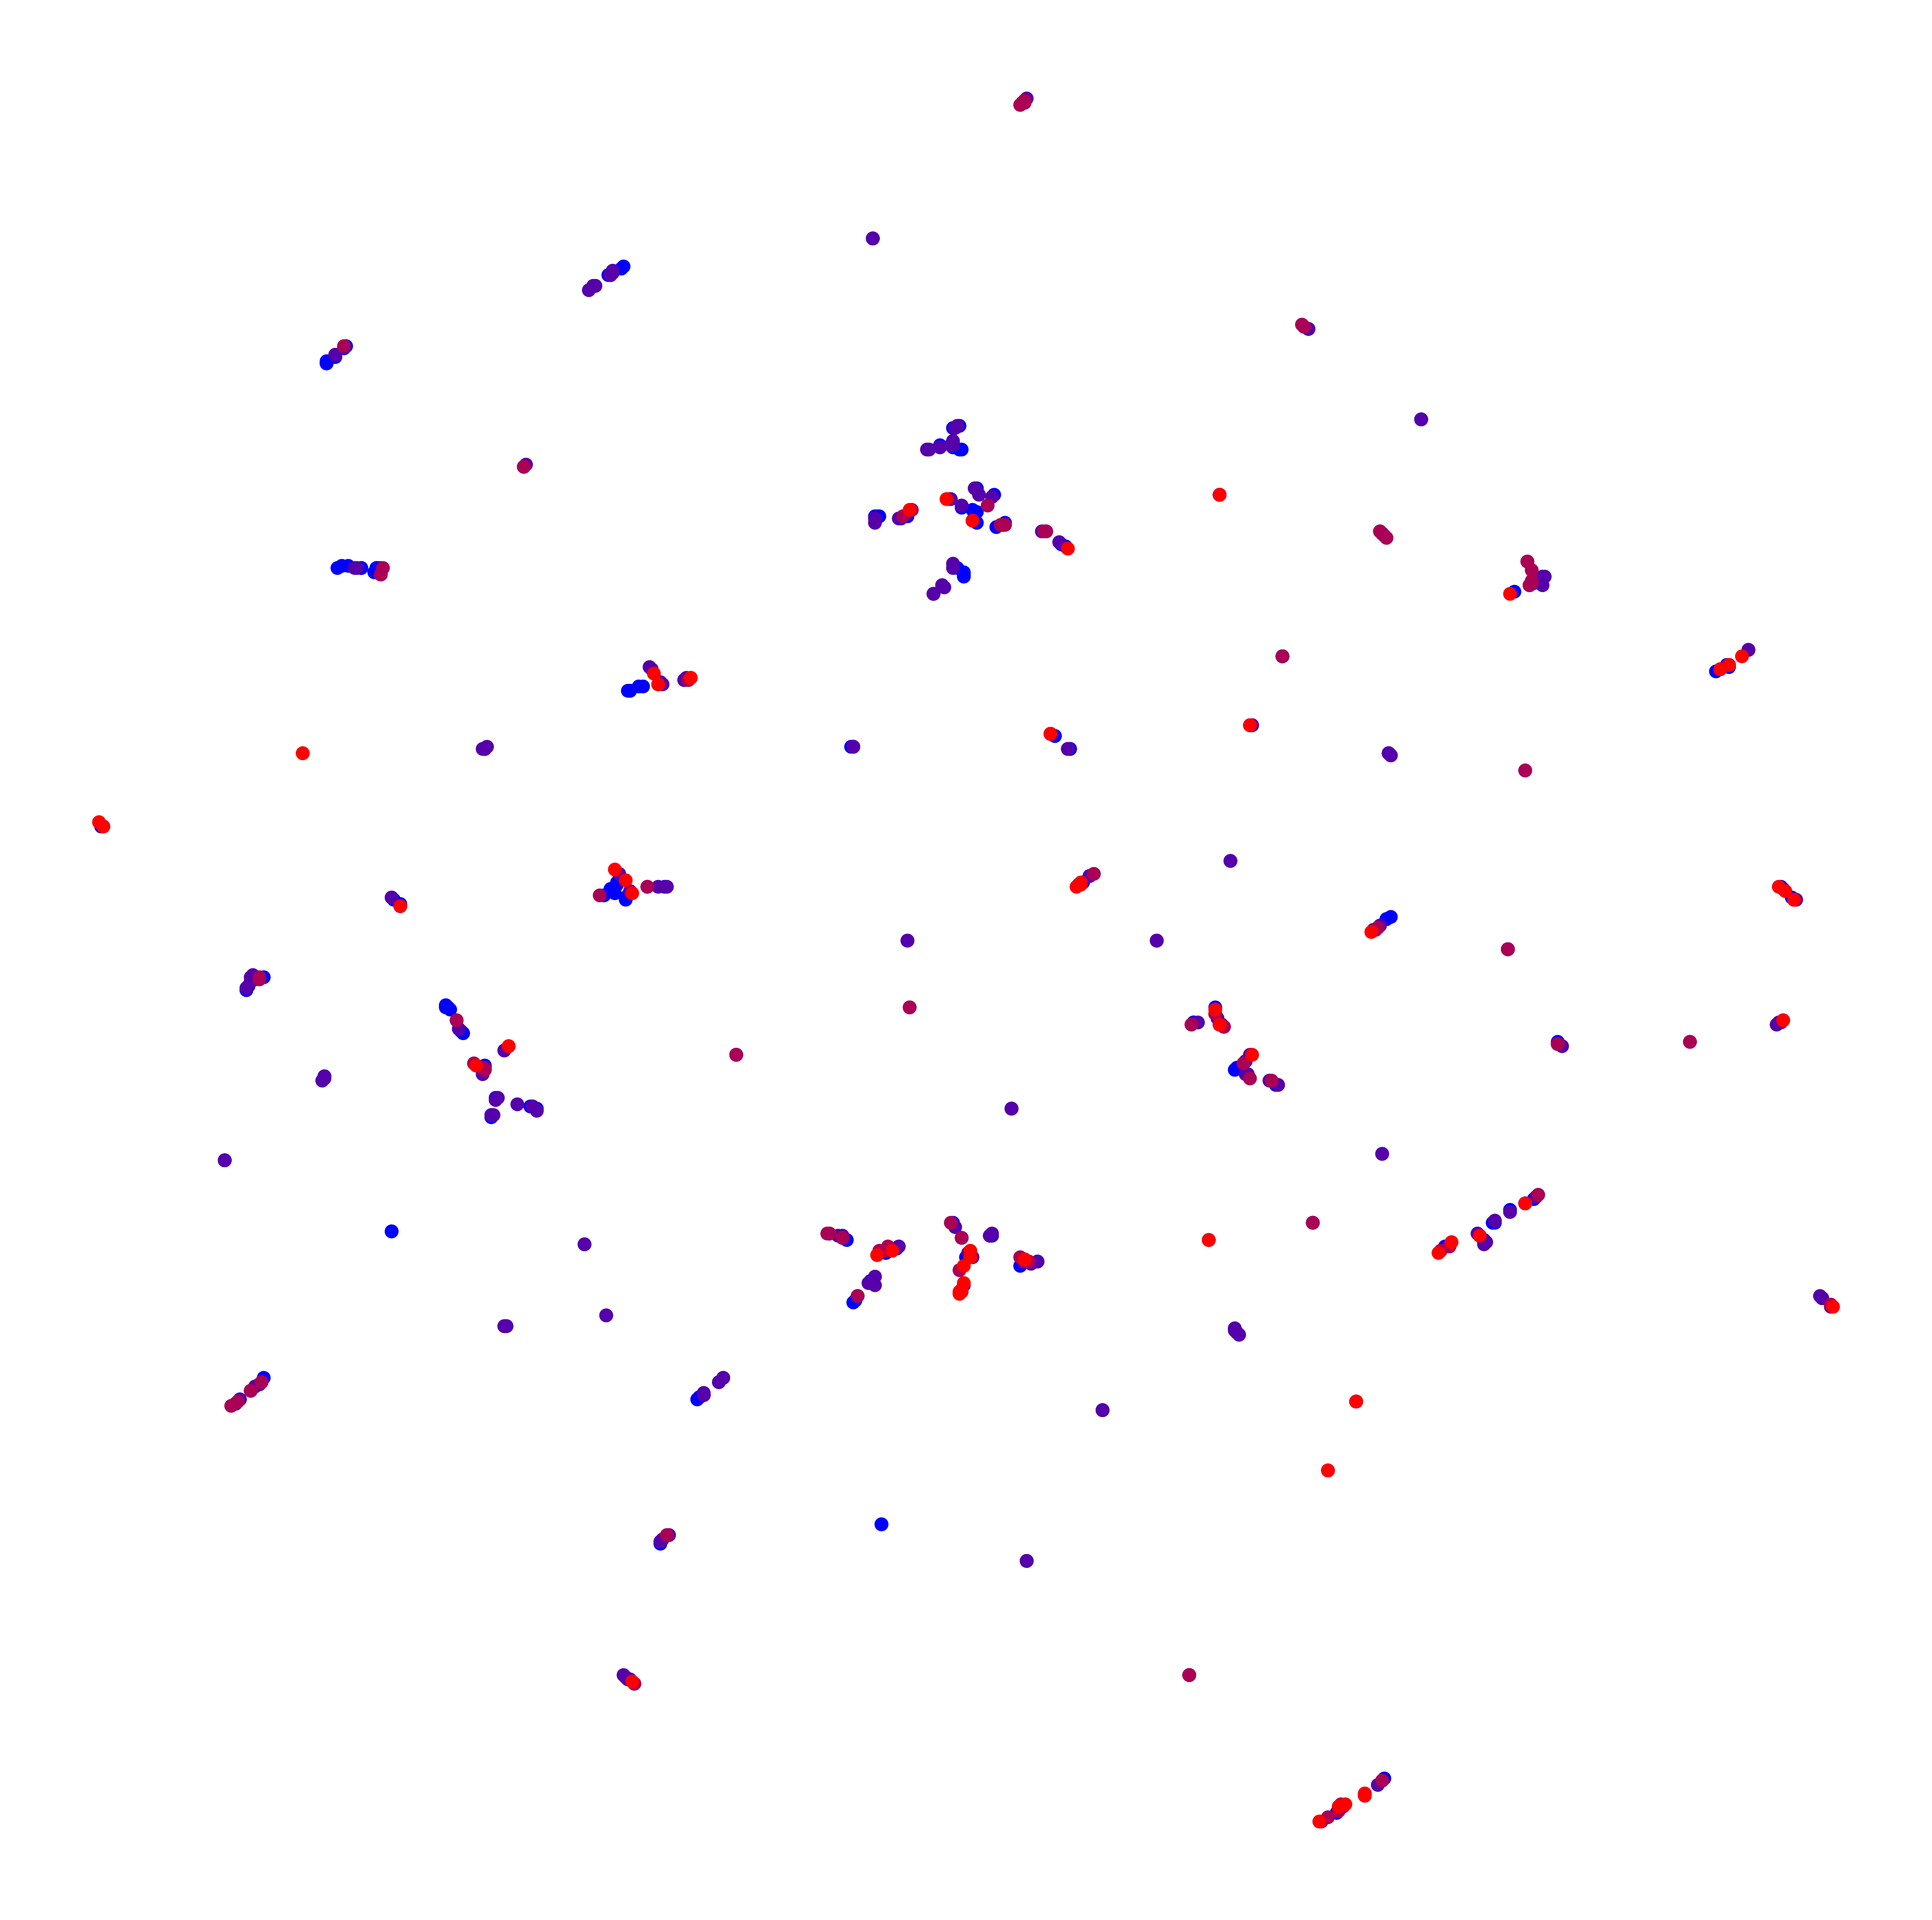

In [18]:
# Fit UMAP reducer without random_state for parallelism
reducer = umap.UMAP(
    #random_state=2,
    n_components=2,
    n_neighbors=2,
    min_dist=0.1,
    metric="hellinger"
)

embedding = reducer.fit_transform(train_data) # run UMAP



scaler = MinMaxScaler(feature_range=(100, 900)) # Scale embeddings to a fixed range (100 to 900)
embedding_scaled = scaler.fit_transform(embedding)
embedding_scaled = embedding_scaled.astype(int)

# embedding_scaled = align_points_to_grid(embedding_scaled)  # Alignment to a grid

# Assign embeddings (x, y) back to 'entities' DataFrame
index_embedding = 0

for index, row in df.iterrows():
    df.loc[index, "x"] = embedding_scaled[:, 0][index_embedding]
    df.loc[index, "y"] = embedding_scaled[:, 1][index_embedding]
    index_embedding += 1

# Plotting
plt.figure(figsize=(20, 20), dpi=300)
plt.axis("off")

# Scatterplot with size based on 'frequency' and color from 'color'
plt.scatter(
    df["x"].to_list(),
    df["y"].to_list(),
    s=50,
    c=df["color"].to_list(),
)

# Labels
# for i, row in df.iterrows():
#     text = plt.annotate(row["name"], xy=(row["x"], row["y"]), ha="center", va="bottom")
#     text.set_fontsize(3)  # Adjust if too small

# Save the plot
plt.savefig("download.png")

## Clustering

In [19]:
clusterer = hdbscan.HDBSCAN(
    # min_samples=10,            # Aumenta el número de clusters reduciendo los puntos necesarios para un área densa
    min_cluster_size=10,       # Tamaño mínimo del cluster; si lo reduces, obtendrás más clusters
    # cluster_selection_epsilon=0.4  # Controla la fusión de clusters cercanos. Reducirlo puede ayudar a obtener más clusters.
)

df["cluster"] = "-1"  # Reset


def cluster_computing(rows, prefix, df):

    embedding = rows[["x", "y"]].to_numpy()
    clusterer.fit(embedding)
    clusters = clusterer.labels_

    # Write cluster number

    for count, (index, row) in enumerate(rows.iterrows()):
        if clusters[count] != -1:
            df.loc[index, "cluster"] = prefix + str(clusters[count])
        else:
            df.loc[index, "cluster"] = str(clusters[count])
    

cluster_computing(
    df.loc[(df["temperature"] > 0)],
    "p_",
    df,
)
cluster_computing(
    df.loc[(df["temperature"] <= 0)],
    "n_",
    df,
)

df.sample(3)

,id,indexed_date,language,media_name,media_url,publish_date,title,url,year,text,...,IND,ORG,word_count,parsed_doc,parsed_lemmas,temperature,color,x,y,cluster
22,bf19e7063a7e281b1c55bd54e3f0e6f53a6114de8ce3cc...,2024-08-22 21:21:18.600522,en,technologyreview.com,technologyreview.com,2024-08-22,Tech that measures our brainwaves is 100 years...,https://www.technologyreview.com/2024/08/22/10...,2024,Tech that measures our brainwaves is 100 years...,...,['Hans Berger' 'Berger' 'Faisal Mushtaq' 'Berg...,['The Checkup' 'MIT Technology Review' 'MIT Te...,1790,Tech that measures our brainwaves is 100 years...,brainwave eeg disease sign consciousness reces...,2,#0000ff,333.0,530.0,p_2
425,716261728cf50ddc8a96897121c207bfecede2b8413c19...,2024-03-01 10:32:45.949577,en,technologyreview.com,technologyreview.com,2023-04-04,Digital simulations open up real-world possibi...,https://www.technologyreview.com/2023/04/04/10...,2023,Sponsored\nDigital simulations open up real-wo...,...,['Peter Koerte' 'Peter Koerte' 'Laurel Ruma' '...,['Digital' 'Siemens' 'withSiemens' 'Siemens' '...,4838,Sponsored\nDigital simulations open up real-wo...,digital simulation world possibility metaverse...,1,#5500aa,530.0,359.0,p_5
280,d09bfca7e243a460d26ec907422979518461e4c3a889ab...,2024-02-19 18:29:38.499538,en,technologyreview.com,technologyreview.com,2023-10-06,mRNA vaccines just won a Nobel Prize. Now they...,https://www.technologyreview.com/2023/10/06/10...,2023,mRNA vaccines just won a Nobel Prize. Now they...,...,['Katalin Karikó' 'Drew Weissman' 'Kati' 'Thom...,['the Nobel Committee for Physiology or Medici...,1411,mRNA vaccines just won a Nobel Prize. Now they...,vaccine nobel prize act scientist mrna bevy va...,1,#5500aa,691.0,516.0,p_9


{'p_5', 'n_3', 'n_1', 'p_3', 'n_0', 'p_4', '-1', 'p_9', 'p_2', 'p_10', 'p_0', 'p_8', 'n_4', 'p_1', 'p_11', 'p_7', 'p_6', 'n_2'}


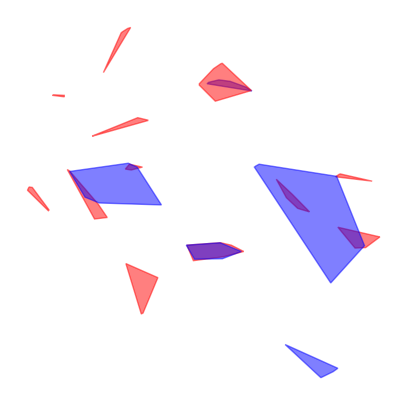

In [20]:
plt.figure(figsize=(5, 5))
plt.axis("off")

clusters = set(df["cluster"].tolist())

print(clusters)

for counter, cluster in enumerate(clusters):

    points = []  # Points
    rows = df.loc[df["cluster"] == cluster]  # Rows

    for index, row in rows.iterrows():
        points.append([row["x"], row["y"]])
    points = np.array(points)

    if len(points) < 3:
        print(len(points))

    hull = ConvexHull(points)  # Hull
    x_hull = np.append(points[hull.vertices, 0], points[hull.vertices, 0][0])
    y_hull = np.append(points[hull.vertices, 1], points[hull.vertices, 1][0])

    if cluster[0] == "p":
        plt.fill(x_hull, y_hull, "--", c="#FF0000", alpha=0.5)  # Plot red
    elif cluster[0] == "n":
        plt.fill(x_hull, y_hull, "--", c="#0000FF", alpha=0.5)  # Plot blue


# Save

In [21]:
export = df.copy()
export.to_csv("src/data/entities.csv", index=False)
export.sample(1)

,id,indexed_date,language,media_name,media_url,publish_date,title,url,year,text,...,IND,ORG,word_count,parsed_doc,parsed_lemmas,temperature,color,x,y,cluster
702,c3714ecdcc6a57363227592aa587797acb9ffc3f3306a3...,2024-08-27 15:01:49.286037,en,technologyreview.com,technologyreview.com,2021-08-04,Podcast: Beating the AI hiring machines,https://www.technologyreview.com/2021/08/04/10...,2021,Podcast: Beating the AI hiring machines\nPart-...,...,['Jamaal Eggleston' 'Ian Siegel' 'ZipRecruiter...,['Work Readiness Instructor' 'Telstra' 'Wasser...,6004,Podcast: Beating the AI hiring machines\nPart-...,podcast machine investigation hiring practice ...,-1,#ff0000,498.0,346.0,n_3


<a href="#Index">Return to Index</a>

<a id="ref5"></a>
<h2>Clusters Topics</h2>

In [22]:
df = pd.read_csv('src/data/entities.csv')
df.head(1)

,id,indexed_date,language,media_name,media_url,publish_date,title,url,year,text,...,IND,ORG,word_count,parsed_doc,parsed_lemmas,temperature,color,x,y,cluster
0,fa04f2a7d53cfa67cbac5db21f72131b58dc5d3ef13560...,2024-09-10 15:28:41.289382,en,technologyreview.com,technologyreview.com,2024-09-10,2024 Innovator of the Year: Shawn Shan builds ...,https://www.technologyreview.com/2024/09/10/11...,2024,2024 Innovator of the Year: Shawn Shan builds ...,...,['Shawn Shan' 'Shawn Shan' 'Shawn Shan' 'Shan'...,['Glaze' 'Nightshade' 'MIT Technology Review' ...,941,2024 Innovator of the Year: Shawn Shan builds ...,innovator shawn shan tool artist shan glaze ni...,2,#0000ff,361.0,534.0,p_2


In [23]:
df['cluster'].value_counts()

cluster
-1      235
p_3      57
p_5      37
p_8      33
n_2      27
n_3      24
p_11     22
p_4      20
p_10     20
p_6      15
p_0      14
p_1      14
p_2      13
n_0      13
n_1      13
p_7      12
p_9      11
n_4      10
Name: count, dtype: int64

In [24]:
df['cluster'].nunique()

18

In [25]:
# Extract keywords for each cluster
def extract_keywords(df, top_n=15, max_features=1000):
    results = []

    for cluster_id, group in df.groupby('cluster'):
        # Vectorize the text
        vectorizer = CountVectorizer(max_features=max_features)
        X = vectorizer.fit_transform(group['parsed_lemmas'])

        # Calculate word frequencies
        word_sums = X.sum(axis=0).A1  # Convert matrix to array
        words_freq = sorted(
            ((word, word_sums[idx]) for word, idx in vectorizer.vocabulary_.items()),
            key=lambda x: x[1], reverse=True
        )

        # Get top keywords
        top_keywords = [word for word, _ in words_freq[:top_n]]

        # Append cluster results
        results.append({'cluster': cluster_id, 'top_keywords': top_keywords})

    return pd.DataFrame(results)
# Usage
keywords_df = extract_keywords(df)

In [26]:
keywords_df

,cluster,top_keywords
0,-1,"[people, system, world, time, problem, story, ..."
1,n_0,"[business, people, customer, organization, tim..."
2,n_1,"[world, worker, time, story, google, people, c..."
3,n_2,"[system, people, data, china, time, government..."
4,n_3,"[people, jennifer, system, job, time, algorith..."
5,n_4,"[system, security, people, researcher, video, ..."
6,p_0,"[story, download, google, china, world, today,..."
7,p_1,"[robot, task, robotic, researcher, system, vid..."
8,p_10,"[business, organization, industry, people, tim..."
9,p_11,"[experience, people, customer, business, intel..."


In [27]:
# Save the DataFrame to an Excel file
keywords_df.to_excel("keywords_per_cluster.xlsx", index=False)

In [28]:
# Read the Excel file with chatgpt names 
topics = pd.read_excel('chatgpt_named.xlsx')
# Merge the two DataFrames on the 'cluster' column
merged_df = df.merge(topics, on='cluster', how='left')
merged_df.head()

,id,indexed_date,language,media_name,media_url,publish_date,title,url,year,text,...,word_count,parsed_doc,parsed_lemmas,temperature,color,x,y,cluster,top_keywords,topic
0,fa04f2a7d53cfa67cbac5db21f72131b58dc5d3ef13560...,2024-09-10 15:28:41.289382,en,technologyreview.com,technologyreview.com,2024-09-10,2024 Innovator of the Year: Shawn Shan builds ...,https://www.technologyreview.com/2024/09/10/11...,2024,2024 Innovator of the Year: Shawn Shan builds ...,...,941,2024 Innovator of the Year: Shawn Shan builds ...,innovator shawn shan tool artist shan glaze ni...,2,#0000ff,361.0,534.0,p_2,"['earthquake', 'model', 'system', 'datum', 'so...",Earthquake Research and Events
1,00dd081954ae78bb816f397a15f0a5f1f08cc32519c4e4...,2024-09-10 11:19:31.849908,en,technologyreview.com,technologyreview.com,2024-09-10,What impact will AI have on video game develop...,https://www.technologyreview.com/2024/09/10/11...,2024,What impact will AI have on video game develop...,...,1366,What impact will AI have on video game develop...,impact video game development working conditio...,2,#0000ff,345.0,625.0,p_4,"['datum', 'system', 'content', 'example', 'len...",Cybersecurity and User Tools
2,dd81b8f5f198bf90f181d1608d05a1955803324090ed07...,2024-09-09 23:21:56.858516,en,technologyreview.com,technologyreview.com,2024-09-09,"To be more useful, robots need to become lazier",https://www.technologyreview.com/2024/09/09/11...,2024,"To be more useful, robots need to become lazie...",...,1772,"To be more useful, robots need to become lazie...",robot smarter processing machine energy world ...,2,#0000ff,215.0,683.0,p_1,"['company', 'model', 'china', 'people', 'datum...",China and Digital Media
3,6e756b42d864508050ba087a650179d05ac91be0b4855d...,2024-09-06 18:23:28.427532,en,technologyreview.com,technologyreview.com,2024-09-06,Roblox is launching a generative AI that build...,https://www.technologyreview.com/2024/09/06/11...,2024,Roblox is launching a generative AI that build...,...,972,Roblox is launching a generative AI that build...,roblox environment snap game environment platf...,2,#0000ff,345.0,625.0,p_4,"['datum', 'system', 'content', 'example', 'len...",Cybersecurity and User Tools
4,3ac10c795421811068dff2c020f48849fad908cb32cb47...,2024-09-05 15:28:38.006311,en,technologyreview.com,technologyreview.com,2024-09-05,Integrating security from code to cloud,https://www.technologyreview.com/2024/09/05/10...,2024,Sponsored\nIntegrating security from code to c...,...,1482,Sponsored\nIntegrating security from code to c...,integrating security code today source softwar...,2,#0000ff,494.0,378.0,p_5,"['model', 'people', 'system', 'company', 'datu...",Space Research and Risks


### Save final dataset

In [29]:
merged_df.to_csv('topics.csv',index=False)

<a href="#Index">Return to Index</a>